In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.tree import _tree
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Define the function tree_to_code (From https://mljar.com/blog/extract-rules-decision-tree/)
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    code = []

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            code.append("{}if {} <= {}:".format(indent, name, np.round(threshold, 2)))
            recurse(tree_.children_left[node], depth + 1)
            code.append("{}else:  # if {} > {}".format(indent, name, np.round(threshold, 2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            code.append("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    return code

In [6]:
# Step 1: Load the Data
df = pd.read_csv('../4-processData/features2.csv')
df.dropna(inplace=True)

# Step 2: Split the Data
X = df.drop('label', axis=1)  # Features
y = df['label']  # Labels

# Step 3: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Step 4: Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=10, max_leaf_nodes=10, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=10, n_estimators=10, random_state=42)

In [8]:
# Step 5: Measure the Accuracy of the Model
accuracy = rf_classifier.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 94.44%


In [ ]:
# Plot all trees in the Random Forest
for i in range(10):
    plt.figure(figsize=(10, 10))
    plot_tree(rf_classifier.estimators_[i], feature_names=X.columns, class_names=rf_classifier.classes_, filled=True)
    plt.title(f"Tree {i+1}")
    plt.show()


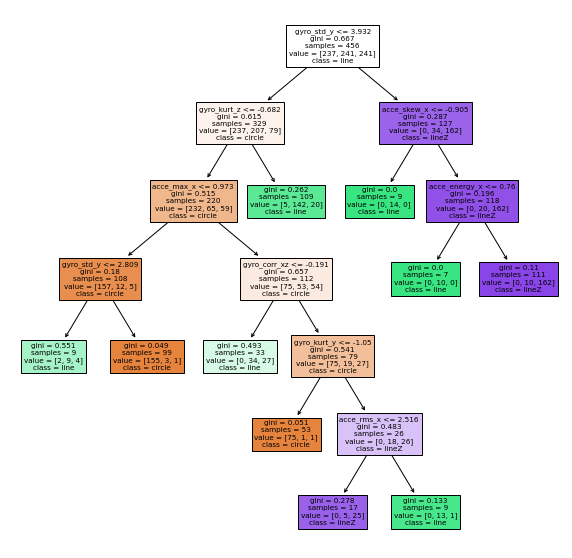

In [30]:
# Plot first tree in the Random Forest
plt.figure(figsize=(10, 10))
plot_tree(rf_classifier.estimators_[5], feature_names=X.columns, class_names=rf_classifier.classes_, filled=True)

plt.savefig('tree6.png', bbox_inches='tight', pad_inches=0)

plt.show()


In [11]:
# Define header for each tree file
header = '''\
def decision_tree_{tree_number}({feature_names}):
'''

with open(f'test_trees.py', 'w') as f:
    # Extract and save each tree
    for i, tree in enumerate(rf_classifier.estimators_):
        code = tree_to_code(tree, feature_names=X.columns.tolist())
        feature_names = ', '.join(X.columns.tolist())
    
        f.write(header.format(tree_number=i, feature_names=feature_names))
        for line in code:
            # Adjusting formatting
            line = line.replace("[[", "[").replace("]]", "]")
            if "return" in line:
                line = line.replace(".", ",")
            f.write(line + '\n')
        f.write('\n')
